# Building a Predictive Model for McAfee

Our objective is to train and evaluate a predictive model that predicts whether employees click on a phishing url to visit a website or not.

## 1. Notebook Styling and Package Management

### Install

In [1]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install optunahub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import xgboost as xgb
import sklearn # The machine learning library we will be using in this entire course
import optuna #hyperparameter tuning
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * # Importing function that can be used to calculate different metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split, cross_val_score, KFold # Importing cross val score & kfold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Importing GridSearchCV
#from sklearn.model_selection import RandomizedSearchCV # Importing RandomSearchCV
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
from sklearn.ensemble import VotingClassifier # Importing Voting Classifier
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting
from sklearn.datasets import load_wine
from sklearn.metrics import make_scorer, roc_auc_score
from plotly.io import show
from optuna.terminator import report_cross_validation_scores
from optuna.visualization import plot_terminator_improvement
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## 2. Load Data

In [4]:
trainInput = pd.read_csv("Data/Phishing_TrainSample.csv") 
testInput = pd.read_csv("Data/Phishing_TestSample.csv")

In [5]:
trainData = trainInput.drop(columns = 'Visit')
trainLabels = LabelEncoder().fit_transform(trainInput.Visit)

testData = testInput.drop(columns = 'Visit')
testLabels = LabelEncoder().fit_transform(testInput.Visit)

### Visualize Data 

In [6]:
#WIP
# Load data
X, y = load_wine(return_X_y=True)
X = pd.DataFrame(trainData, columns=[f'Feature_{i}' for i in range(X.shape[1])])

# Function to check for outliers in each column using IQR
def check_outliers_per_column(data):
    outlier_report = {}
    
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        # Detect outliers
        outliers = data[(data[column] < (Q1 - 1.5 * IQR)) | (data[column] > (Q3 + 1.5 * IQR))]
        outlier_count = outliers.shape[0]
        
        if outlier_count > 0:
            outlier_report[column] = outlier_count

    if outlier_report:
        print("Outliers detected in the following columns:")
        for col, count in outlier_report.items():
            print(f" - {col}: {count} outliers")
    else:
        print("No outliers detected in any column.")

# Check for outliers in each feature
check_outliers_per_column(X)


No outliers detected in any column.


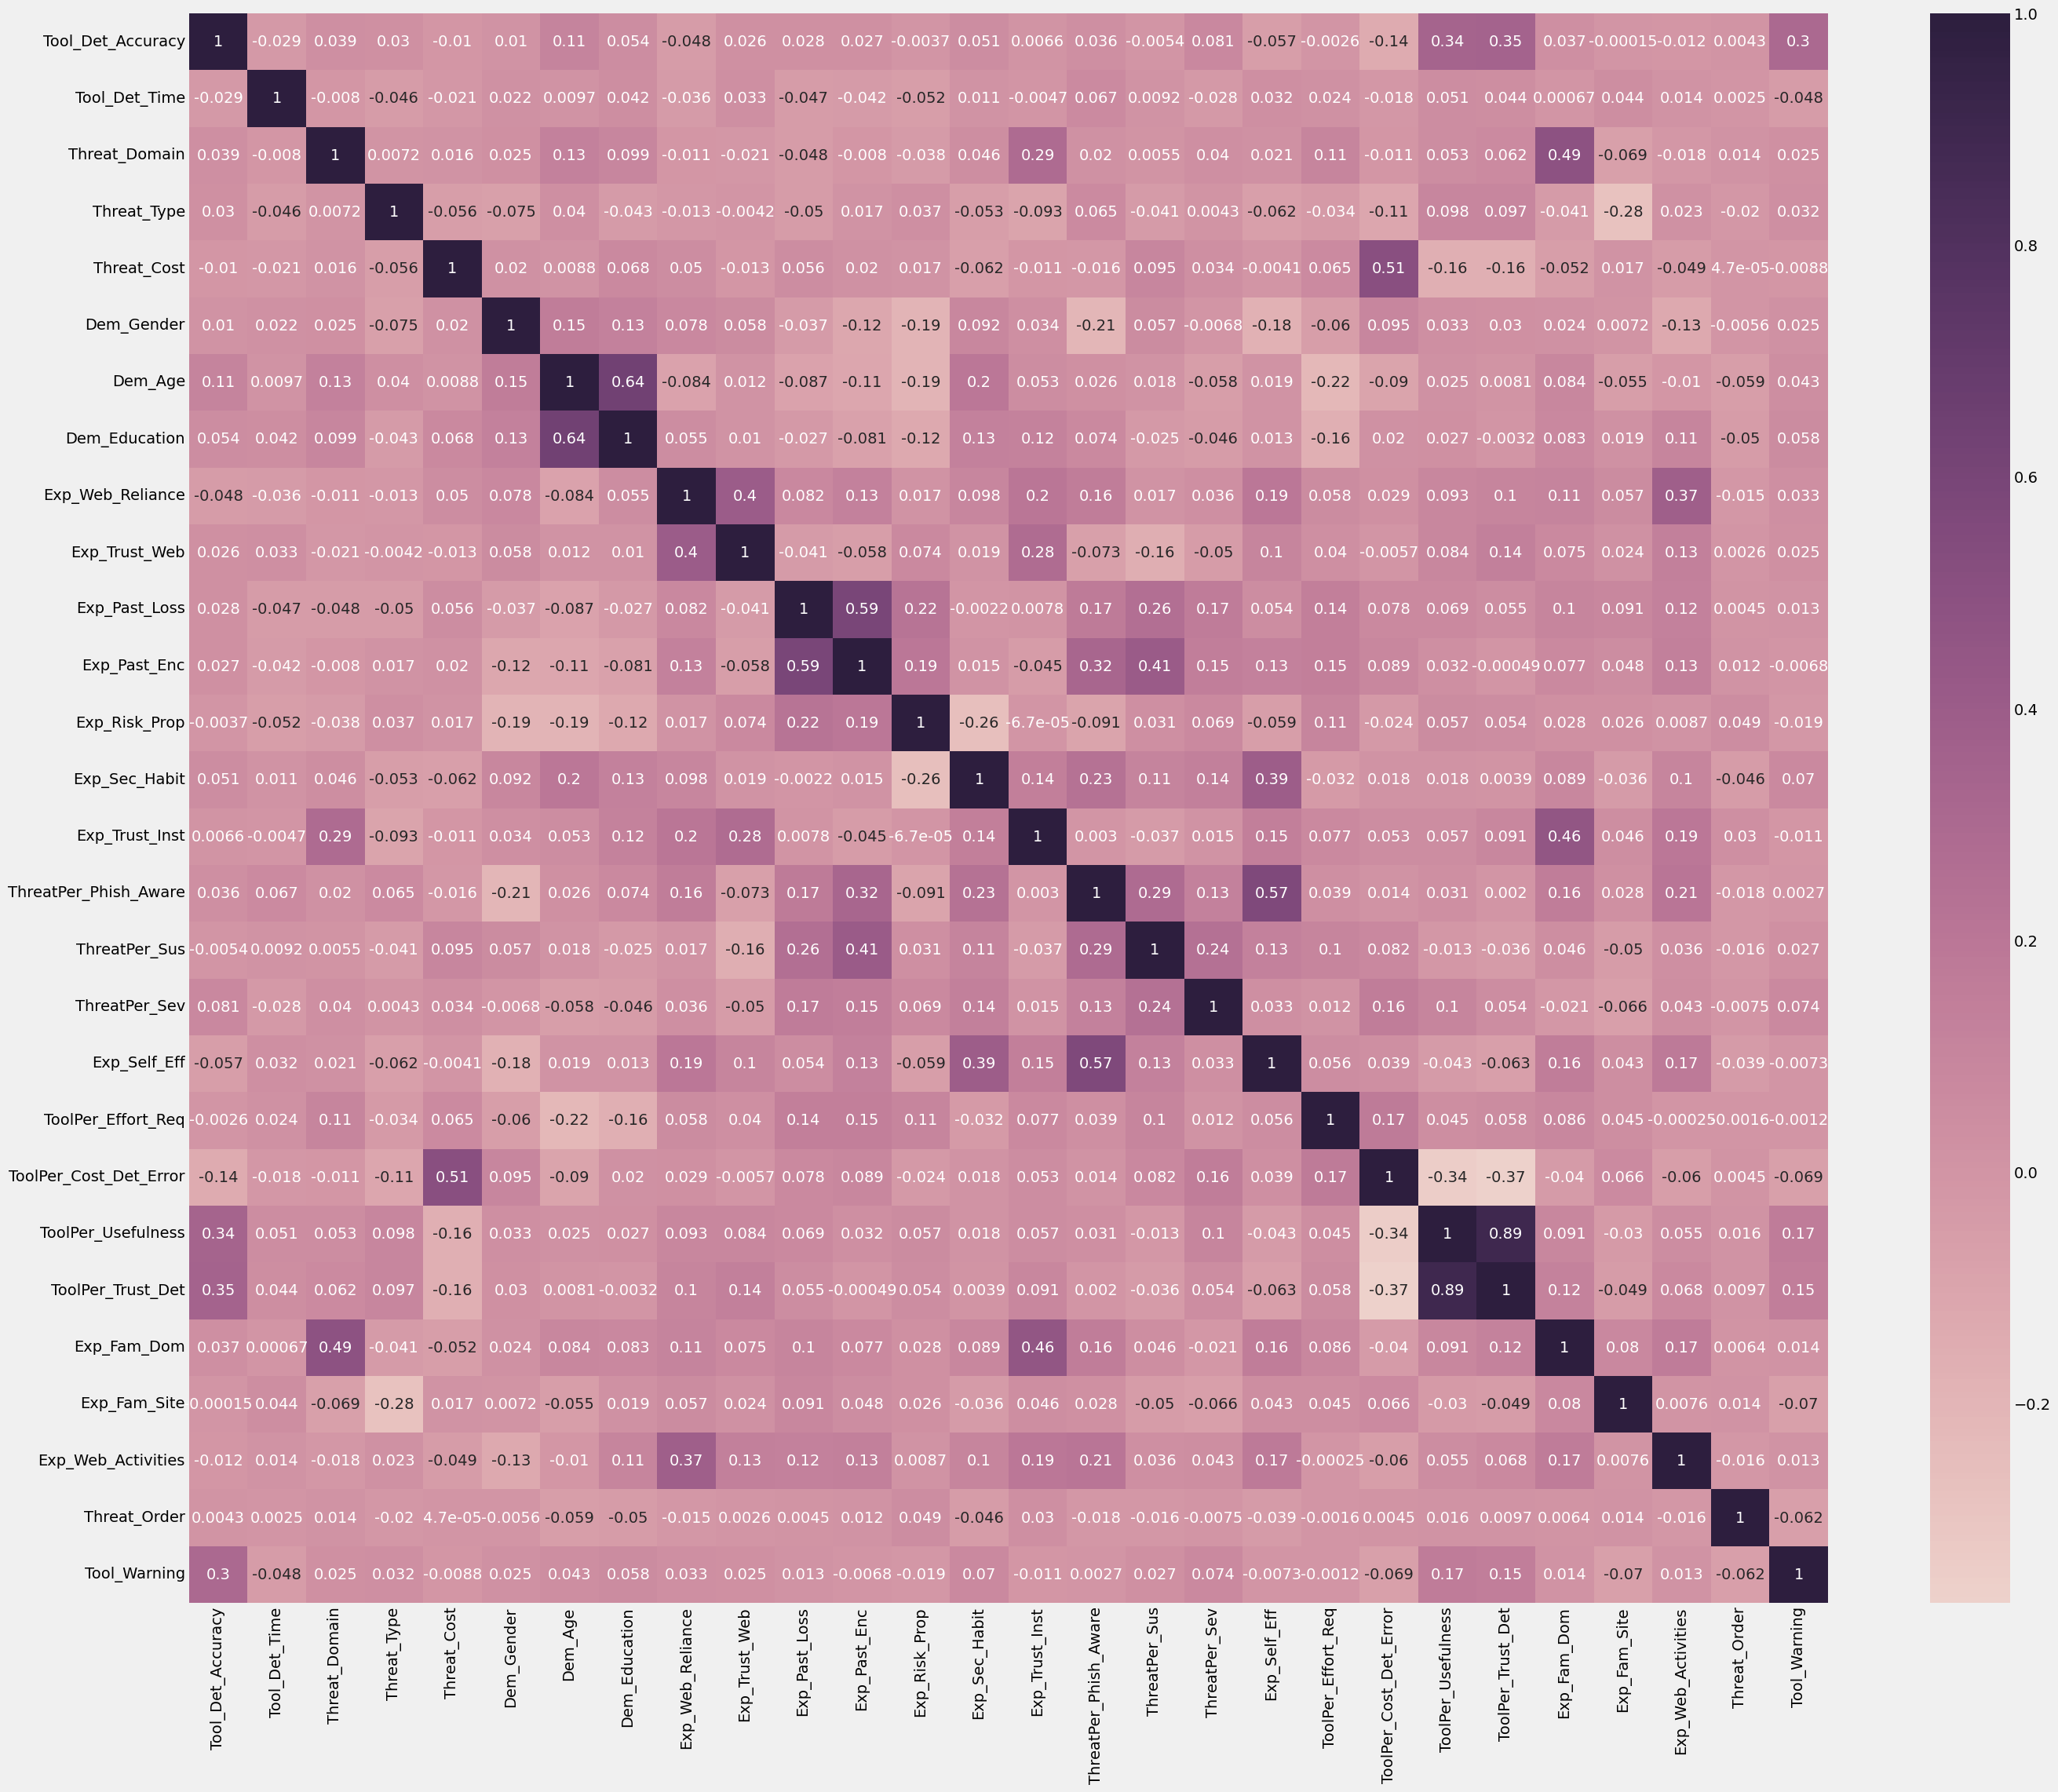

Highly correlated pairs: [('Dem_Age', 'Dem_Education'), ('Dem_Education', 'Dem_Age'), ('ToolPer_Usefulness', 'ToolPer_Trust_Det'), ('ToolPer_Trust_Det', 'ToolPer_Usefulness')]


In [7]:
# Plot heatmap to visualize correlations
corr_matrix = trainData.corr()

plt.figure(figsize=(30, 25))
sns.heatmap(trainData.corr(), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

# Identify pairs of features with high correlation
high_corr_pairs = [(col1, col2) for col1 in corr_matrix.columns for col2 in corr_matrix.columns 
                   if col1 != col2 and corr_matrix.loc[col1, col2] > 0.6]
print(f"Highly correlated pairs: {high_corr_pairs}")

## 3. Train a RandomForest Classifier

In [8]:
clf = RandomForestClassifier(random_state = 1)
clf.fit(trainData, trainLabels)

RandomForestClassifier(random_state=1)

## 4. Evaluate the Classifier Using the Training Data (Not Recommended)

We first import custom functions from a custom package called custom_functions. File custom_functions.py should be in the active directory.

In [9]:
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

#### 4.1. Confusion Matrix:

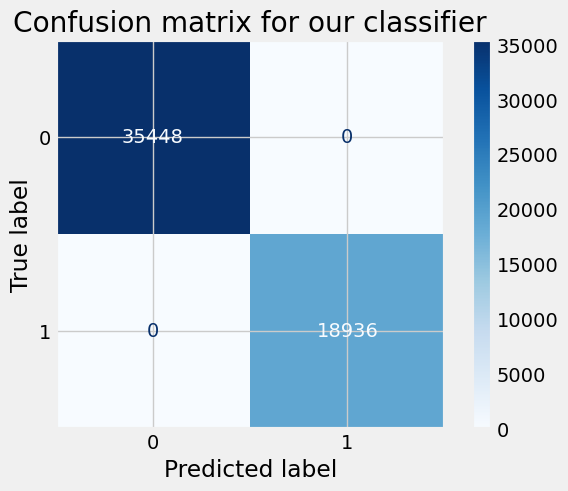

In [10]:
plot_conf_mat(clf, # The classifier object
              trainData, # The test data set aside for evaluation in train_test_split
              trainLabels # Actual labels
             )

#### 4.2. Accuracy, Precision, Recall, AUC, and F1:

In [11]:
predictedProbabilities = clf.predict_proba(trainData)
predictedLabels = clf.predict(trainData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, trainLabels)

Accuracy: 100.00
PrecisionNegative: 100.00
PrecisionPositive: 100.00
RecallNegative: 100.00
RecallPositive: 100.00
AUC Score: 100.00



In [12]:
print("F1 Score:",f1_score(trainLabels, predictedLabels, average='micro'))

F1 Score: 1.0


#### 4.3. ROC Curve:

In [13]:
positiveProbabilities = predictedProbabilities[:,1]

AUC Score = 100.000


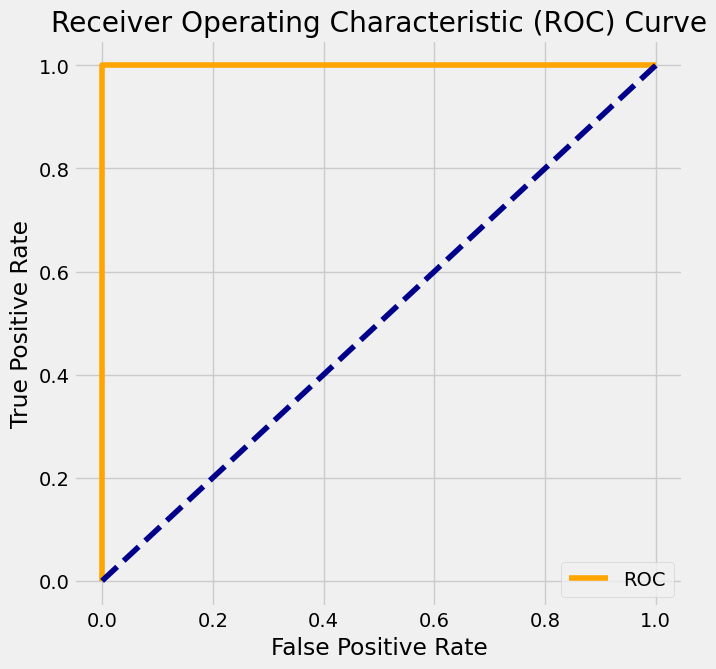

In [14]:
plot_roc_curve(trainLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

#### 4.4 Log-loss:

In [15]:
print("Log-Loss Score:",log_loss(trainLabels, predictedLabels)) 

Log-Loss Score: 2.2204460492503136e-16


## 5. Evaluate the Classifier Using the Testing Data (Recommended)

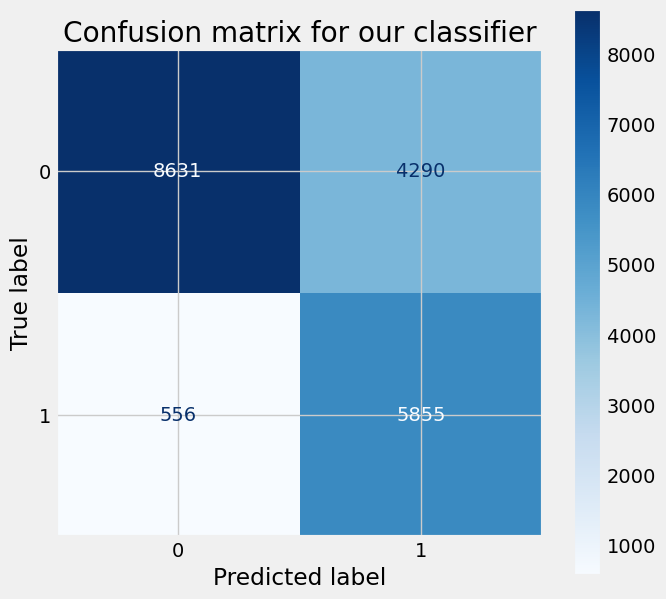

In [16]:
plot_conf_mat(clf, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [17]:
predictedProbabilities = clf.predict_proba(testData)
predictedLabels = clf.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 74.93
PrecisionNegative: 93.95
PrecisionPositive: 57.71
RecallNegative: 66.80
RecallPositive: 91.33
AUC Score: 85.31



In [18]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.7493275398303332


AUC Score = 85.314


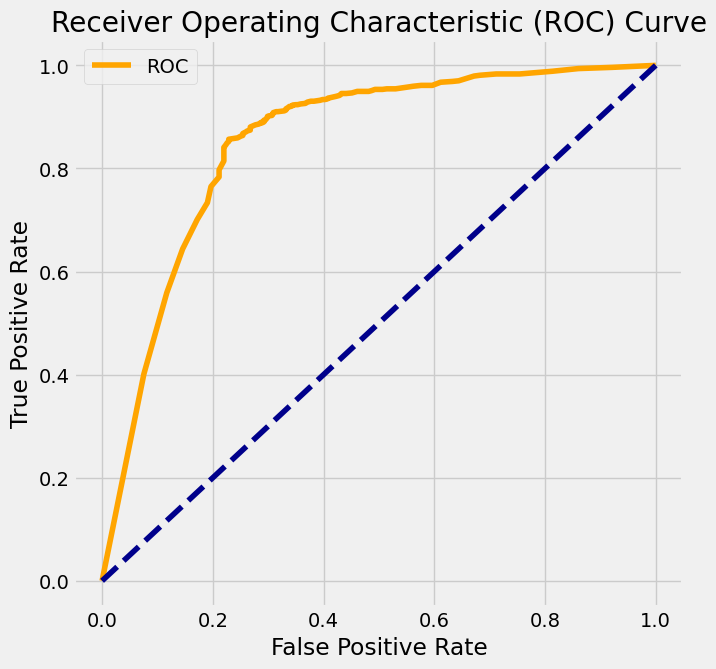

In [19]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

In [20]:
print("Log-Loss Score:",log_loss(testLabels, predictedProbabilities[:,1])) 

Log-Loss Score: 2.4481252531606144


## 6. Train and Evaluate after Fine-tuning the Hyper-parametrs:

What are Hyper Parameters?

Hyper parameters are more like handles available to control the output or the behavior of the algorithm used for modeling. They can be supplied to algorithms as arguments. For eg: model= DecisionTreeClassifier(criterion=’entropy’), here the criterion entropy is the hyper parameter passed.

Typically, we can use one of the following two methods to fine-tune the hyperparameters in the algorithms:

* RandomSearchCV (only a few samples are randomly selected)
* GridSearchCV (considers all possible combinations of hyperparameters)

The first one, RandomSearchCV, requires the user to provide a range of values for each parameter. For instance, we select range [2,10] for max_depth in XGBoost. It also requires the user to provide the number of values (n_iter) that should be drawn for the hyperparameters. We also set n_iter to 2. That means RandomSearchCV will randomly draw two values between 2 and 9 (inclusive) and use each to build XGBoost classifiers. If max_depth is the only parameter we are tuning for, then RandomSearchCV will create 2 XGBoost classifiers. However, if we are tuning for another parameter (let's say learning_rate), then RandomSearchCV will build two models by selecting two combinations of values for max_depth and learning_rate. 

GridSearchCV, on the other hand, will build a classifier for every possible value the user provides. All possible permutations of the hyperparameters for a particular model are used to build models. The performance of each model is evaluated, and the best-performing one is selected. Since GridSearchCV uses every combination to build and evaluate the model performance, this method is highly computationally expensive. 

Given that GridSearchCV is computationally expensive, it is a good practice to start with RandomSearchCV to narrow down the range of values for each hyperparameter. Then, GridSearchCV can be used to find the best values within that range:


#### 6.1. RandomSearchCV

In [21]:
%%time
params = {
    "n_estimators" : [100,200,300,500],
    "max_depth" : np.arange(2,10,1),
    "learning_rate" : np.arange(0.1,0.9,0.1)
}

clf = XGBClassifier(objective="binary:logistic", 
                    n_jobs=16,
                    random_state = 1)

rs_model = RandomizedSearchCV(clf,
                              param_distributions=params,
                              n_iter=10, # We are asking for five models
                              scoring='roc_auc',
                              cv=5,
                              verbose=3,
                              random_state = 1)

#model fitting
rs_model.fit(trainData,trainLabels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.6, max_depth=7, n_estimators=500;, score=1.000 total time=   1.3s
[CV 2/5] END learning_rate=0.6, max_depth=7, n_estimators=500;, score=1.000 total time=   1.3s
[CV 3/5] END learning_rate=0.6, max_depth=7, n_estimators=500;, score=1.000 total time=   1.4s
[CV 4/5] END learning_rate=0.6, max_depth=7, n_estimators=500;, score=1.000 total time=   1.4s
[CV 5/5] END learning_rate=0.6, max_depth=7, n_estimators=500;, score=1.000 total time=   1.4s
[CV 1/5] END learning_rate=0.2, max_depth=2, n_estimators=300;, score=0.963 total time=   0.4s
[CV 2/5] END learning_rate=0.2, max_depth=2, n_estimators=300;, score=0.962 total time=   0.4s
[CV 3/5] END learning_rate=0.2, max_depth=2, n_estimators=300;, score=0.964 total time=   0.4s
[CV 4/5] END learning_rate=0.2, max_depth=2, n_estimators=300;, score=0.962 total time=   0.4s
[CV 5/5] END learning_rate=0.2, max_depth=2, n_estimators=300;, score=0.965 total ti

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=16,
                                           num_parallel_tree=None,
                                           random_state=1, ...),
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=1, scoring='roc_auc', verbose=3)

In [22]:
#parameters selected
rs_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=16,
              num_parallel_tree=None, random_state=1, ...)

Based on the output above, we see that the following values are selected as the best values for each hyperparameter:

* n_estimators: 200
* max_depth: 7 
* learning_rate: 0.6 

We can now use GridSearchCV with ranges of values around the values RandomSearchCV provided:

In [23]:
%%time
params = {
    "n_estimators" : [175,200,225],
    "max_depth" : [6,7,8],
    "learning_rate" : [0.5,0.6,0.7]
}

clf = XGBClassifier(objective="binary:logistic", 
                    n_jobs=16,
                    random_state = 1)

gs_model = GridSearchCV(clf,
                              param_grid=params,
                              scoring='roc_auc',
                              cv=2,
                              verbose=3)

#model fitting
gs_model.fit(trainData,trainLabels)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END learning_rate=0.5, max_depth=6, n_estimators=175;, score=1.000 total time=   0.5s
[CV 2/2] END learning_rate=0.5, max_depth=6, n_estimators=175;, score=1.000 total time=   0.7s
[CV 1/2] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=1.000 total time=   0.5s
[CV 2/2] END learning_rate=0.5, max_depth=6, n_estimators=200;, score=1.000 total time=   0.5s
[CV 1/2] END learning_rate=0.5, max_depth=6, n_estimators=225;, score=1.000 total time=   0.6s
[CV 2/2] END learning_rate=0.5, max_depth=6, n_estimators=225;, score=1.000 total time=   0.6s
[CV 1/2] END learning_rate=0.5, max_depth=7, n_estimators=175;, score=1.000 total time=   0.5s
[CV 2/2] END learning_rate=0.5, max_depth=7, n_estimators=175;, score=1.000 total time=   0.5s
[CV 1/2] END learning_rate=0.5, max_depth=7, n_estimators=200;, score=1.000 total time=   0.6s
[CV 2/2] END learning_rate=0.5, max_depth=7, n_estimators=200;, score=1.000 total ti

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=16, num_parallel_tree=None,
                                     random_state=1, ...),
             param_grid={'learning_rate': [0.5, 0.6, 0.7],
                         'max_depth': [6, 7, 8],
                         'n_estimators': [175, 200, 225]},
             scoring='roc_auc', verbose=3)

In [24]:
#parameters selected
gs_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=175, n_jobs=16,
              num_parallel_tree=None, random_state=1, ...)

Based on the output above, we see that the following values are selected as the best values for each hyperparameter:

* n_estimators: 200
* max_depth: 6 
* learning_rate: 0.5 

Now, we take the best estimator and evaluate it using the testing data:

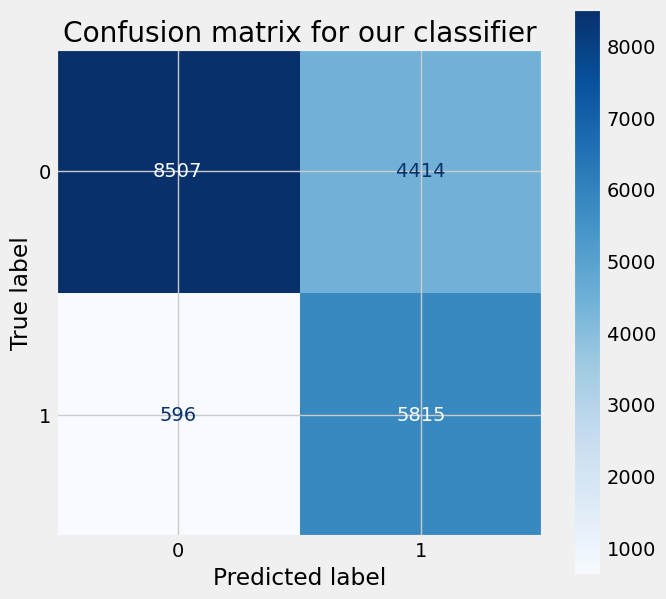

In [25]:
plot_conf_mat(gs_model.best_estimator_, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [26]:
predictedProbabilities = gs_model.best_estimator_.predict_proba(testData)
predictedLabels = gs_model.best_estimator_.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 74.08
PrecisionNegative: 93.45
PrecisionPositive: 56.85
RecallNegative: 65.84
RecallPositive: 90.70
AUC Score: 85.48



In [27]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.7408441961514587


AUC Score = 85.476


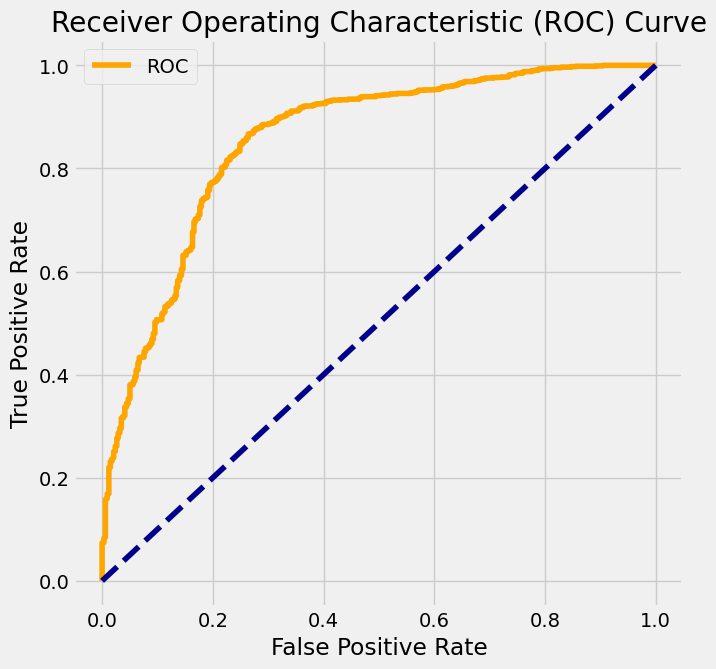

In [28]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

In [29]:
print("Log-Loss Score:",log_loss(testLabels, predictedProbabilities[:,1])) 

Log-Loss Score: 1.4801758995438452


## 7. Balance Classes:

Occasionally, we might have a data set in which the proportion of positives to negatives is not balanced. For instance, in our data set, for every single positive case (Visit), there are three negative cases (Exist):

In [30]:
trainLabels.mean()

0.3481906443071492

Therefore, we can balance the data by giving more weight to the positive class. In a sense, misclassifying a positive case will be equal to misclassfying three negative cases:

In [31]:
# XGBoost parameter settings.
#'n_estimators': 146, 'max_depth': 16, 'learning_rate': 0.04204765164562287, 
#'subsample': 0.6074102497091562, 'colsample_bytree': 0.6731547244451318, 'gamma': 4.729217804062513, 
#'min_child_weight': 6}
depth=16
estimators=146
lr=.04204765164562287


# fit the unweighted model
clf = XGBClassifier(objective="binary:logistic", 
                    max_depth=depth, 
                    n_estimators=estimators, 
                    learning_rate=lr, 
                    n_jobs=16,
                    subsample= 0.6074102497091562,
                    colsample_bytree = 0.6731547244451318, 
                    gamma = 4.729217804062513,
                     # Give three times more weight to the positive class (Visit)
                    random_state = 1)
clf.fit(trainData, trainLabels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6731547244451318, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.729217804062513,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04204765164562287,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=146, n_jobs=16,
              num_parallel_tree=None, random_state=1, ...)

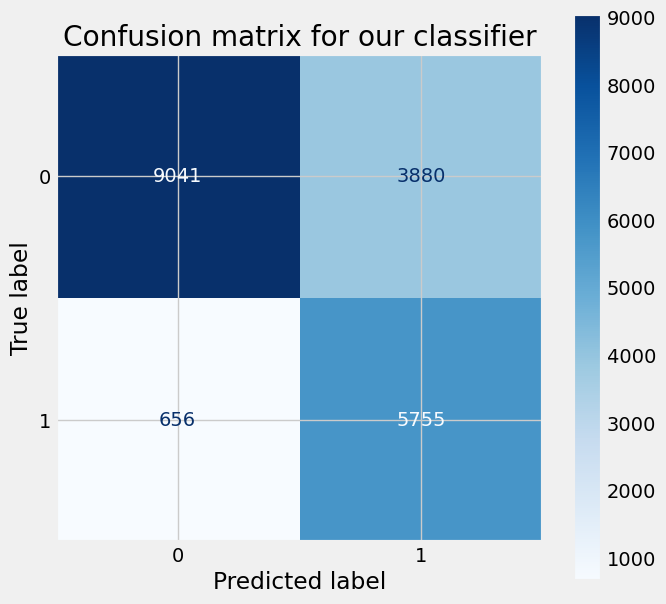

In [32]:
plot_conf_mat(clf, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [33]:
predictedProbabilities = clf.predict_proba(testData)
predictedLabels = clf.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 76.54
PrecisionNegative: 93.24
PrecisionPositive: 59.73
RecallNegative: 69.97
RecallPositive: 89.77
AUC Score: 87.27



In [34]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.7653631284916201


AUC Score = 87.270


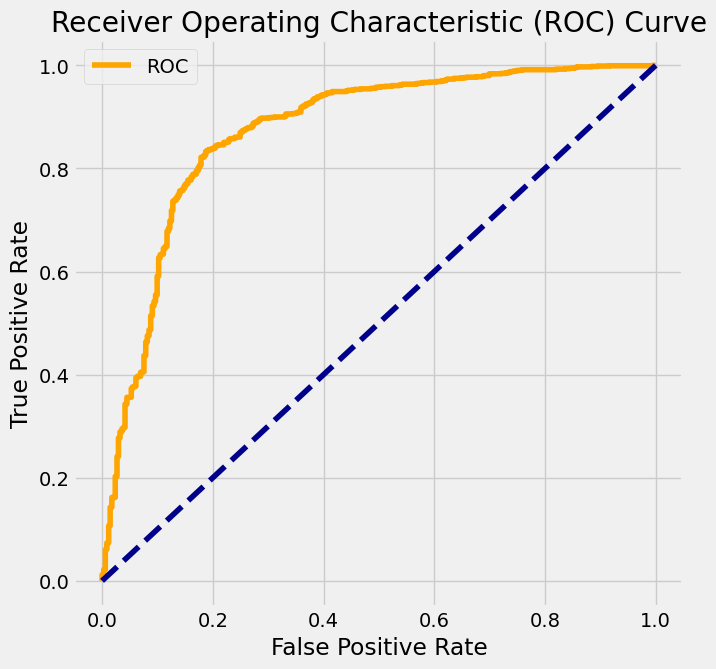

In [35]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

In [36]:
print("Log-Loss Score:",log_loss(testLabels, predictedProbabilities[:,1])) 

Log-Loss Score: 0.6014558558385605


### RF Optuna

In [37]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Train the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(trainData, trainLabels)

    # Evaluate the model
    predictions = model.predict(testData)
    accuracy = accuracy_score(testLabels, predictions)

    return accuracy  # Optuna will maximize this value

# Create a study and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Train the final model with the best hyperparameters
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, random_state=42)
final_model.fit(trainData, trainLabels)

# Evaluate the final model
final_predictions = final_model.predict(testData)
final_accuracy = accuracy_score(testLabels, final_predictions)
print("Final accuracy with best hyperparameters:", final_accuracy)

[I 2025-01-14 22:43:24,942] A new study created in memory with name: no-name-3bc860b7-59ad-4835-b846-badbbd9ed4d9
[I 2025-01-14 22:43:29,098] Trial 0 finished with value: 0.6683736809435133 and parameters: {'n_estimators': 493, 'max_depth': 18, 'min_samples_split': 0.5380979834734768, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6683736809435133.
[I 2025-01-14 22:43:30,134] Trial 1 finished with value: 0.6683736809435133 and parameters: {'n_estimators': 117, 'max_depth': 4, 'min_samples_split': 0.498710786118705, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6683736809435133.
[I 2025-01-14 22:43:34,440] Trial 2 finished with value: 0.6873577488102628 and parameters: {'n_estimators': 276, 'max_depth': 8, 'min_samples_split': 0.17199070468941074, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.6873577488102628.
[I 2025-01-14 22:43:35,703] Trial 3 finished with value: 0.6683736809435133 and parameters: {'n_estimators': 138, 'max_depth': 5, 'min_samples_split': 0.465

Best hyperparameters: {'n_estimators': 344, 'max_depth': 10, 'min_samples_split': 0.10051679763044585, 'min_samples_leaf': 3}
Best accuracy: 0.6995654872749845
Final accuracy with best hyperparameters: 0.6995654872749845


### XGBoost Optuna

In [38]:
%%time
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # Train the model
    model = XGBClassifier(**param, use_label_encoder=False, random_state=42, eval_metric='logloss')
    model.fit(trainData, trainLabels)

    # Get predicted probabilities for AUC calculation
    probabilities = model.predict_proba(testData)[:, 1]  # Probabilities for the positive class (class 1)
    
    # Compute the AUC
    auc = roc_auc_score(testLabels, probabilities)

    return auc  # Optuna will maximize this value

# Create a study and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best AUC:", study.best_value)

# Train the final model with the best hyperparameters
best_params = study.best_params
final_xgb = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
final_xgb.fit(trainData, trainLabels)

# Evaluate the final model
final_probabilities = final_xgb.predict_proba(testData)[:, 1]
final_auc = roc_auc_score(testLabels, final_probabilities)
print("Final AUC with best hyperparameters:", final_auc)


[I 2025-01-14 22:45:26,342] A new study created in memory with name: no-name-eece5e0a-1be4-4d1c-997e-c0273bce0e4d
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[22:45:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


[I 2025-01-14 22:45:26,968] Trial 0 finished with value: 0.871694723672096 and parameters: {'n_estimators': 101, 'max_depth': 26, 'learning_rate': 0.054368158966862874, 'subsample': 0.6942477888628127, 'colsample_bytree': 0.5675482955775866, 'gamma': 7.653237444654089, 'min_child_weight': 8}. Best is trial 0 with value: 0.871694723672096.
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning:

[22:45:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


[I 2025-01-14 22:45:28,481] Trial 1 finished with value: 

Best hyperparameters: {'n_estimators': 117, 'max_depth': 12, 'learning_rate': 0.015739388582168418, 'subsample': 0.6076352890024349, 'colsample_bytree': 0.7199484223443672, 'gamma': 3.4348776645277783, 'min_child_weight': 9}
Best AUC: 0.8800625897769668
Final AUC with best hyperparameters: 0.8800625897769668
CPU times: user 1min 12s, sys: 357 ms, total: 1min 12s
Wall time: 37 s


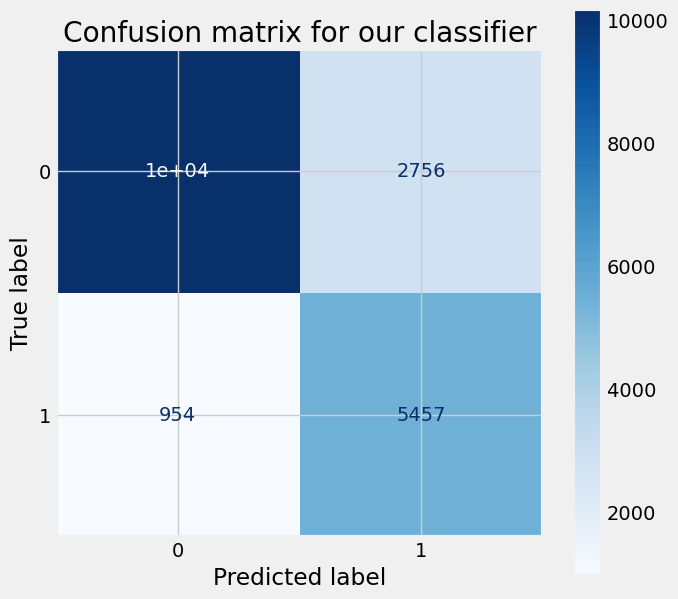

In [39]:
plot_conf_mat(final_xgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [40]:
predictedProbabilities = final_xgb.predict_proba(testData)
predictedLabels = final_xgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 80.81
PrecisionNegative: 91.42
PrecisionPositive: 66.44
RecallNegative: 78.67
RecallPositive: 85.12
AUC Score: 88.01



In [41]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.8080902131181461


AUC Score = 88.006


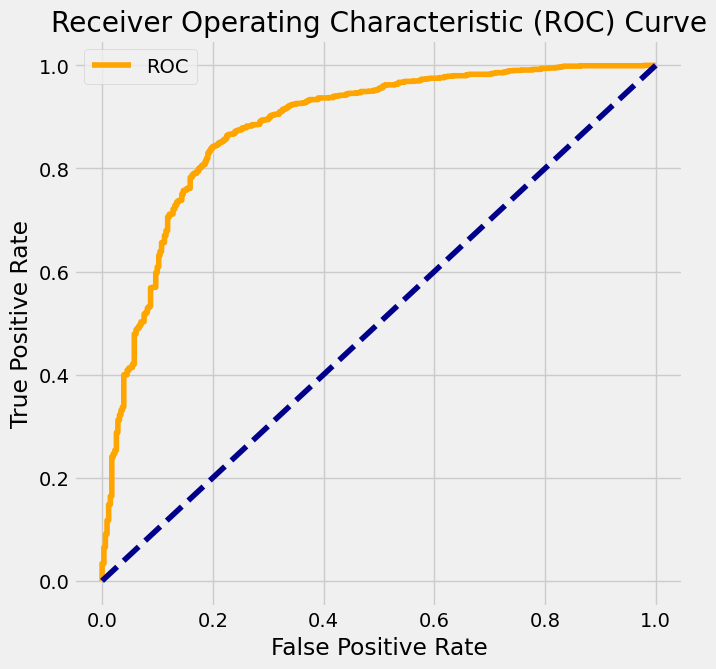

In [42]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

In [43]:
print("Log-Loss Score:",log_loss(testLabels, predictedProbabilities[:,1])) 

Log-Loss Score: 0.4461581801271928


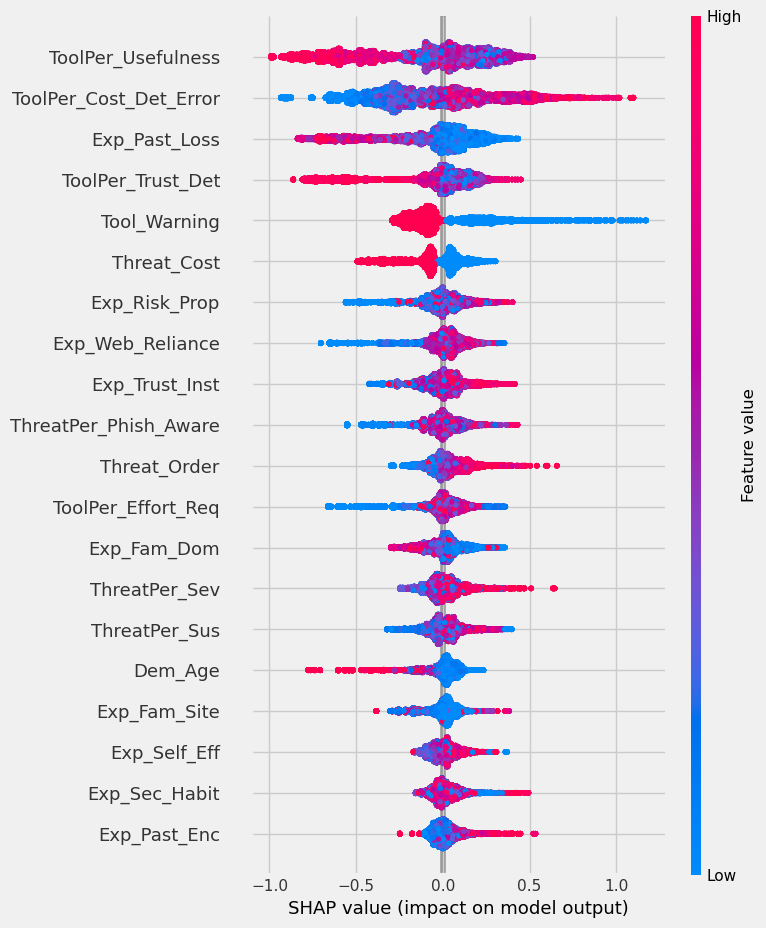

In [44]:
import shap
# Initialize SHAP explainer
explainer = shap.Explainer(final_xgb)
shap_values = explainer(trainData)
# Summary plot
shap.summary_plot(shap_values, trainData)

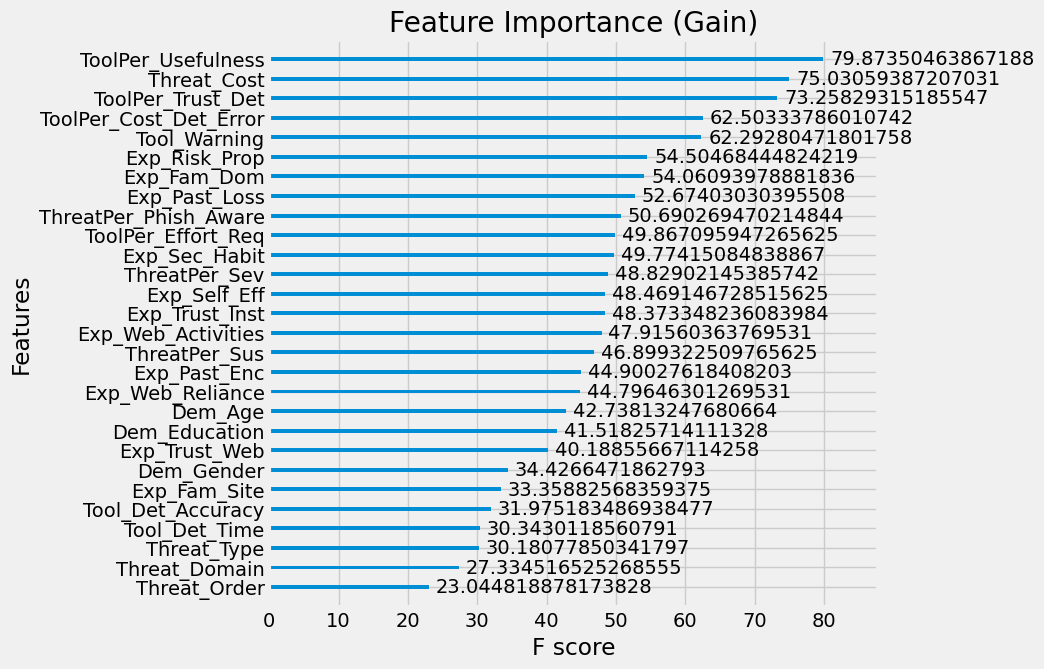

In [45]:
# Plot feature importance based on 'gain'
xgb.plot_importance(final_xgb, importance_type='gain')
plt.title("Feature Importance (Gain)")
plt.show()

In [46]:
def objective(trial):
    X, y = load_wine(return_X_y=True)
    
    clf = XGBClassifier(
        reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 15),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.4, 1.0),
        subsample=trial.suggest_float("subsample", 0.4, 1.0),
        min_child_weight=trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        n_estimators=trial.suggest_int("n_estimators", 50, 500),
        eval_metric='auc'  # Optimizing for AUC
    )

    # Updated scorer using response_method instead of needs_proba
    scorer = make_scorer(roc_auc_score, response_method='predict_proba', multi_class='ovr')

    # Cross-validation using AUC as the scoring metric
    scores = cross_val_score(clf, X, y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring=scorer)

    report_cross_validation_scores(trial, scores)
    return scores.mean()

# Optimize for maximum AUC
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

# Plot the improvement across trials
fig = plot_terminator_improvement(study, plot_error=True)
show(fig)


[I 2025-01-14 22:49:06,780] A new study created in memory with name: no-name-4e55d3a1-ebaa-43ca-b178-03b87b564de3
[I 2025-01-14 22:49:07,603] Trial 0 finished with value: 0.9993040911616763 and parameters: {'reg_alpha': 3.1160742892652715e-05, 'reg_lambda': 0.2431259088997316, 'max_depth': 8, 'colsample_bytree': 0.8391525532700563, 'subsample': 0.6025824471982515, 'min_child_weight': 0.0445869892168194, 'learning_rate': 0.004344476981496344, 'n_estimators': 425}. Best is trial 0 with value: 0.9993040911616763.
[I 2025-01-14 22:49:07,899] Trial 1 finished with value: 0.9997435897435898 and parameters: {'reg_alpha': 2.3683871612608908e-06, 'reg_lambda': 1.107361994667776e-08, 'max_depth': 7, 'colsample_bytree': 0.47168261124443733, 'subsample': 0.45508121776850746, 'min_child_weight': 2.6127792773078355, 'learning_rate': 0.011719733432785895, 'n_estimators': 148}. Best is trial 1 with value: 0.9997435897435898.
[I 2025-01-14 22:49:08,199] Trial 2 finished with value: 0.998770757828343 an

## 8. Apply the Model to Kaggle Data:

In [47]:
kaggleTest = pd.read_csv("Data/Phishing_KaggleTest.csv") 
kaggleTest['id'] = kaggleTest.index
kaggleTest.columns

Index(['Tool_Det_Accuracy', 'Tool_Det_Time', 'Threat_Domain', 'Threat_Type',
       'Threat_Cost', 'Dem_Gender', 'Dem_Age', 'Dem_Education',
       'Exp_Web_Reliance', 'Exp_Trust_Web', 'Exp_Past_Loss', 'Exp_Past_Enc',
       'Exp_Risk_Prop', 'Exp_Sec_Habit', 'Exp_Trust_Inst',
       'ThreatPer_Phish_Aware', 'ThreatPer_Sus', 'ThreatPer_Sev',
       'Exp_Self_Eff', 'ToolPer_Effort_Req', 'ToolPer_Cost_Det_Error',
       'ToolPer_Usefulness', 'ToolPer_Trust_Det', 'Exp_Fam_Dom',
       'Exp_Fam_Site', 'Exp_Web_Activities', 'Threat_Order', 'Tool_Warning',
       'id'],
      dtype='object')

In [48]:
kaggleTest['score'] = final_xgb.predict_proba(kaggleTest.drop(columns = 'id'))[:,1]

In [49]:
#kaggleTest['score'] = clf.predict_proba(kaggleTest.drop(columns = 'id'))[:,1]

In [50]:
kaggleTest[['id','score']].to_csv("Data/Kaggle_Submission.csv", index = False)

Please submit to https://www.kaggle.com/t/cced5ccc913f4919ac2ab685bae0f0aa

Each team should make at least three submissions before it is closed. 

# SVM

## SVM Poly

In [51]:
scaler = StandardScaler()
trainData = scaler.fit_transform(trainData)
testData = scaler.transform(testData)

In [52]:
%%time
# Initialize the SVM Model with probability=True
svm_model = SVC(kernel='poly', C=1.0, probability=True, random_state=201)

# Train the Model
svm_model.fit(trainData, trainLabels)

# Make Predictions
y_pred = svm_model.predict(testData)

CPU times: user 5min 49s, sys: 126 ms, total: 5min 49s
Wall time: 5min 49s


In [53]:
# Evaluate the Model
predictedProbabilities = svm_model.predict_proba(testData)
predictedLabels = svm_model.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 77.76
PrecisionNegative: 91.72
PrecisionPositive: 61.74
RecallNegative: 73.35
RecallPositive: 86.65
AUC Score: 84.59



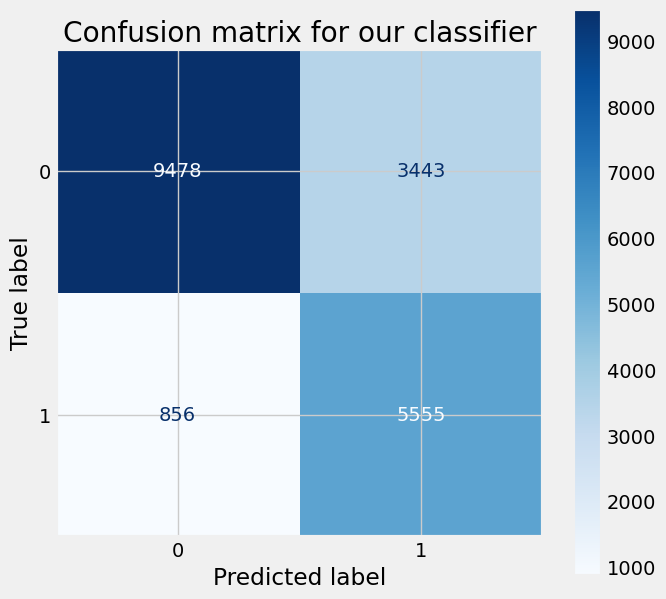

In [54]:
# Confusion Matrix
plot_conf_mat(svm_model, testData, testLabels)

### GridSearch HP Tuning SGDClassifier

%%time
# Define the hyperparameter grid
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber'],  # Hinge for SVM, log_loss for logistic regression
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['optimal', 'adaptive', 'invscaling'],
    'eta0': [0.01, 0.1, 1],
    'max_iter': [1000, 2000, 3000]
}

# Initialize the SGDClassifier
sgd = SGDClassifier(random_state=201)

# Initialize GridSearchCV with ROC-AUC optimization
grid_search = GridSearchCV(estimator=sgd, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(trainData, trainLabels)

# Best hyperparameters
print("Best Hyperparameters (Optimized for ROC-AUC):", grid_search.best_params_)

# Predict probabilities for ROC-AUC (for binary classification)
y_proba_best = grid_search.best_estimator_.decision_function(testData)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(testLabels, y_proba_best)
print("ROC-AUC Score:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(testLabels, y_proba_best)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Tuned SGDClassifier")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
y_pred_best = grid_search.best_estimator_.predict(testData)
cm_best = confusion_matrix(testLabels, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best)
disp_best.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix - Tuned SGDClassifier (ROC-AUC Optimized)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Optuna SGDClassifier

In [55]:
%%time
import optuna
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

def objective(trial):
    # Hyperparameters to tune
    C = trial.suggest_float('C', 1e-3, 10, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    
    # Initialize SVM with suggested hyperparameters
    model = SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, probability=True, random_state=201)
    
    # Train the model
    model.fit(trainData, trainLabels)
    
    # Predict probabilities for ROC-AUC
    y_proba = model.predict_proba(testData)[:, 1]
    
    # Compute ROC-AUC
    return roc_auc_score(testLabels, y_proba)

# Create and optimize the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# Train the best model
best_model = SVC(**study.best_params, probability=True, random_state=201)
best_model.fit(trainData, trainLabels)


[I 2025-01-14 22:55:47,371] A new study created in memory with name: no-name-690af001-594b-4956-9f72-43a70ed8766d
[I 2025-01-14 23:14:06,258] Trial 2 finished with value: 0.8072038470563186 and parameters: {'C': 8.273844014705837, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: 0.8072038470563186.
[I 2025-01-14 23:45:56,557] Trial 0 finished with value: 0.8372717104727623 and parameters: {'C': 0.02873313460733995, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale'}. Best is trial 0 with value: 0.8372717104727623.
[I 2025-01-14 23:52:15,661] Trial 1 finished with value: 0.8109190074606095 and parameters: {'C': 0.00267244190976974, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}. Best is trial 0 with value: 0.8372717104727623.
[I 2025-01-15 00:08:39,887] Trial 4 finished with value: 0.6781116172042503 and parameters: {'C': 0.0032233272039012524, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.8372717104727623.
[I 2025-01-15 00:44:28,049] Trial 6 finished 

CPU times: user 21h 40min 41s, sys: 1min 31s, total: 21h 42min 13s
Wall time: 11h 1min 5s


SVC(C=0.35375339488993524, kernel='poly', probability=True, random_state=201)

In [62]:
import pickle
filename = 'SVC.sav'
pickle.dump(best_model, open(filename, 'wb'))

In [ ]:
#reload model
filename = 'SVC.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [56]:
# Evaluate the Model
predictedProbabilities = best_model.predict_proba(testData)
predictedLabels = best_model.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 77.77
PrecisionNegative: 90.97
PrecisionPositive: 62.00
RecallNegative: 74.10
RecallPositive: 85.17
AUC Score: 85.17



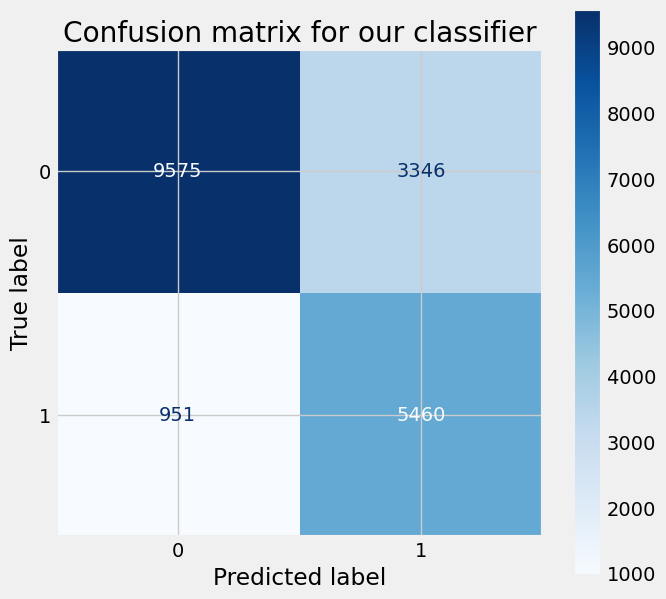

In [57]:
# Confusion Matrix
plot_conf_mat(best_model, testData, testLabels)

AUC Score = 85.170


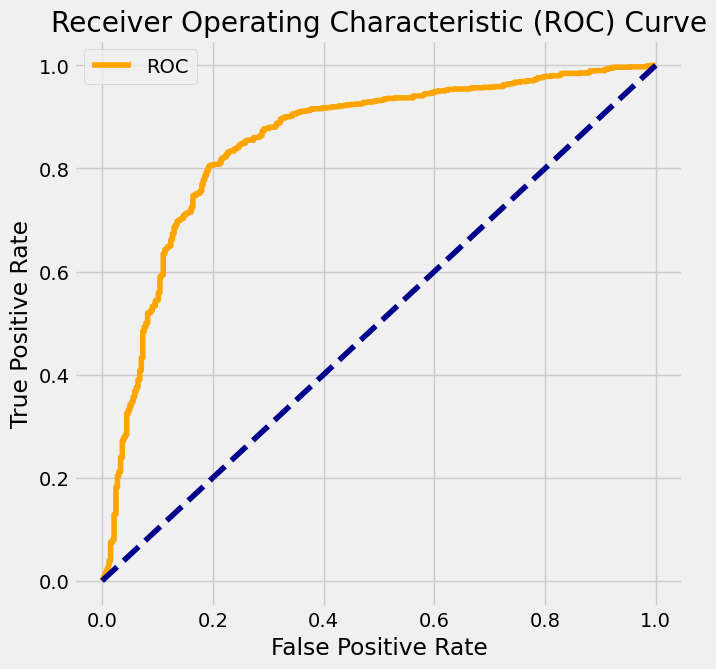

In [63]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

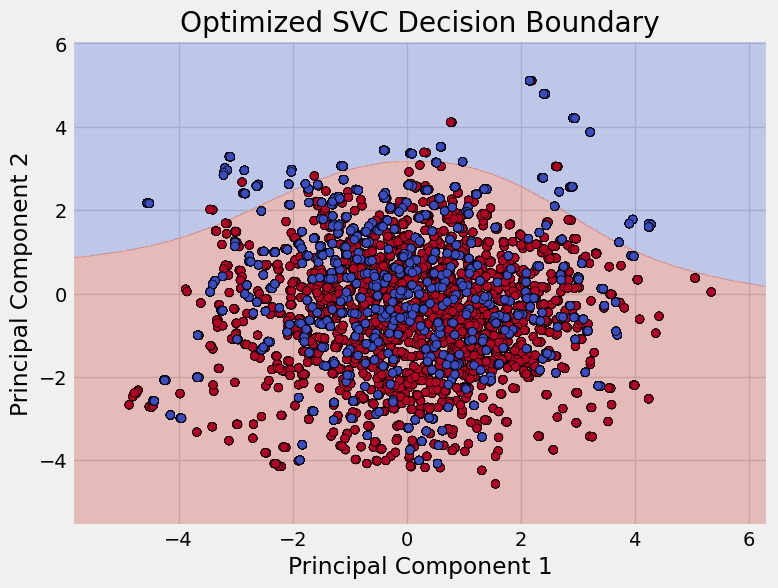

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def plot_decision_boundary(model, X, y):
    # Step size for the mesh grid
    h = 0.02  
    
    # Apply PCA to reduce to 2D for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Define the range for the plot
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

    # Create the mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Project the grid back to the original feature space
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_original = pca.inverse_transform(grid_points)

    # Predict using the model on the original feature space
    Z = model.predict(grid_original)
    Z = Z.reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Optimized SVC Decision Boundary')
    plt.show()

# Plot the decision boundary with the fixed function
plot_decision_boundary(best_model, trainData, trainLabels)


# Create the Optuna study for maximization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# Best hyperparameters and ROC-AUC
print("Best Hyperparameters (Optuna):", study.best_params)
print("Best ROC-AUC Score:", study.best_value)

# Train the best model
best_model = SVC(**study.best_params, probability=True, random_state=201)
best_model.fit(trainData, trainLabels)

# Predictions
y_pred = best_model.predict(testData)
y_proba = best_model.predict_proba(testData)[:, 1]

# Evaluation Metrics
print("Accuracy:", accuracy_score(testLabels, y_pred))
print("Classification Report:\n", classification_report(testLabels, y_pred))

# Confusion Matrix
cm = confusion_matrix(testLabels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix (Optuna-Tuned SVM)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(testLabels, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(testLabels, y_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Optuna-Tuned SVM")
plt.legend()
plt.grid(True)
plt.show()
